# Visualization of various plots and finding the perfect mexican ice cream
## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
import nltk
import re
from PIL import Image
from nltk.corpus import stopwords
import matplotlib.image as mpimg

## Loading datasets

In [3]:
ds_business = pd.read_csv('yelp_business.csv')

In [4]:
ds_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


### What is the distribution of stars in reviews?

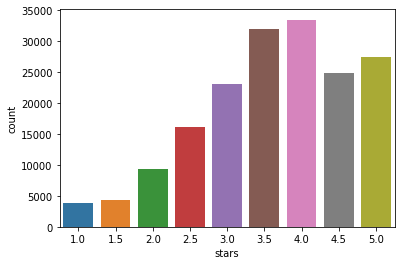

In [5]:
sns.countplot(x='stars', data=ds_business)

### What is average review count for users on yelp?

In [6]:
ds_business['review_count'].describe()

count    174567.000000
mean         30.137059
std          98.208174
min           3.000000
25%           4.000000
50%           8.000000
75%          23.000000
max        7361.000000
Name: review_count, dtype: float64

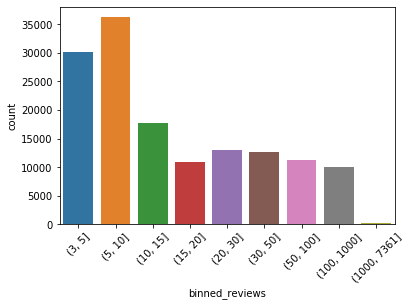

In [7]:
ds_business['binned_reviews']= pd.cut(ds_business['review_count'], bins=[3, 5, 10, 15, 20, 30, 50, 100, 1000, 7361])
sns.countplot(x='binned_reviews', data=ds_business)
g = plt.xticks(rotation=45)

### Which state/country has the most reviews?

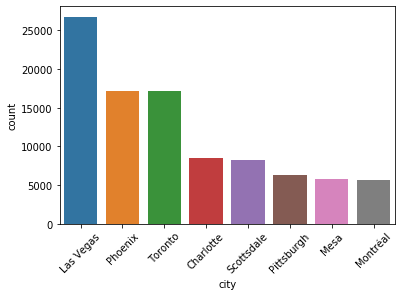

In [8]:
sns.countplot(x='city', data=ds_business, order=ds_business.city.value_counts().iloc[:8].index)
g = plt.xticks(rotation=45)

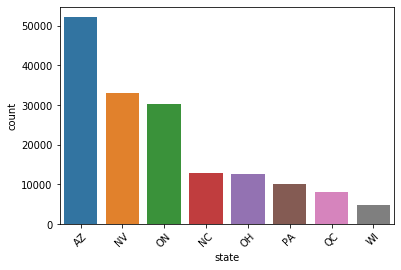

In [9]:
sns.countplot(x='state', data=ds_business, order=ds_business.state.value_counts().iloc[:8].index)
g = plt.xticks(rotation=45)

### Which sectors have the most reviews?

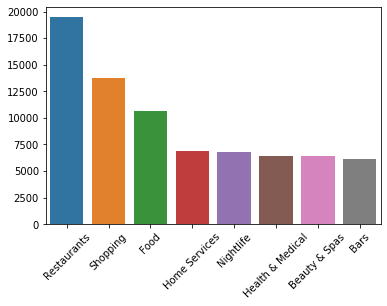

In [10]:
business_categories=' '.join(ds_business['categories'])
indi = pd.DataFrame(business_categories.split(';'), columns=['categories'])
x = indi.categories.value_counts()
ds_categories=pd.DataFrame(x.sort_values(ascending=False))
sns.barplot(ds_categories.index, ds_categories.values.ravel(), order=ds_categories.categories.iloc[:8].index)
g = plt.xticks(rotation=45)

We use distribution visualized in this graph in our categorization approach, where we train model on restaurant and shopping reviews. Trained model is then used for categorization of unseen reviews.

## Semantic analysis of various categories and businesses
  
We will visualize, which words are most common for shopping and restaurant categories.  
Last we will try to find the best mexican ice cream

In [11]:
ds_review = pd.read_csv('yelp_review.csv')

In [12]:
ds_restaurants = ds_business[ds_business['categories'].str.contains('Restaurants')]
ds_shopping = ds_business[(ds_business['categories'].str.contains('Shopping'))]
ds_mexico = ds_business[(ds_business['categories'].str.contains('Restaurants')) & (ds_business['categories'].str.contains('Mexican'))]

We take use 5 businesses based on star rating and review count

In [13]:
best_mexico_idx = ds_mexico.sort_values(by=['stars', 'review_count'], ascending=False).head(5).index
best_restaurants_idx = ds_restaurants.sort_values(by=['stars', 'review_count'], ascending=False).head(5).index
best_shopping_idx = ds_shopping.sort_values(by=['stars', 'review_count'], ascending=False).head(5).index

In [14]:
best_mexico = ds_mexico.loc[best_mexico_idx]
bmr= best_mexico.business_id.values

best_shops = ds_shopping.loc[best_shopping_idx]
bs= best_shops.business_id.values

best_restaurant = ds_restaurants.loc[best_restaurants_idx]
br= best_restaurant.business_id.values

In [15]:
stop_words =  set(stopwords.words('english'))
stop_words.add('place') # ambiguous word

In [16]:
def clean_ds(ds):
    ds.loc[:,"cleaned_text"] = ds.text.apply(lambda x : str.lower(x))
    ds.loc[:,"cleaned_text"] = ds.cleaned_text.apply(lambda x : " ".join(re.findall('[\w]+',x)))
    def remove_stopWords(s):
        s = ' '.join(word for word in s.split() if word not in stop_words)
        return s
    ds.loc[:,"cleaned_text"] = ds.cleaned_text.apply(lambda x: remove_stopWords(x))
    return ds

def plt_category(idx_lst):
    for restaurant  in idx_lst:
        ds_best = ds_review.loc[ds_review['business_id']==restaurant]
        name = ds_business[ds_business['business_id']==restaurant].name.unique()[0]
        cleaned = clean_ds(ds_best)
        text = ' '.join(review for review in cleaned.cleaned_text)
        
        wc = wordcloud.WordCloud(stopwords=stop_words, background_color="white").generate(text)
        f = plt.imshow(wc)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        plt.title(name)
        plt.show()

### Word cloud of shopping businesses

/home/dub/Projects/o2/env/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dub/Projects/o2/env/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


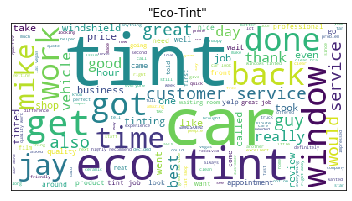

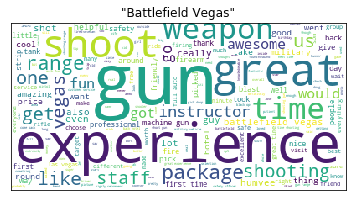

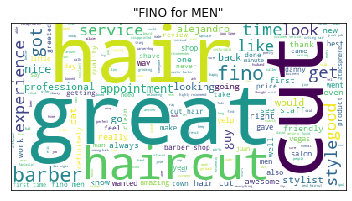

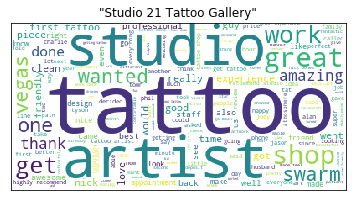

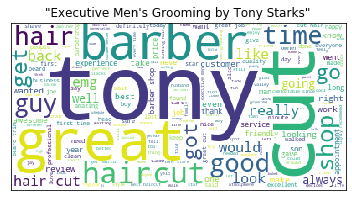

In [17]:
plt_category(bs) 

### Word cloud of best restaurants according to yelp

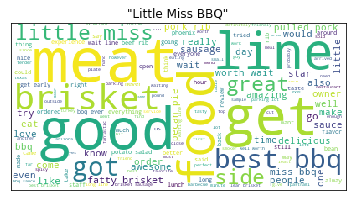

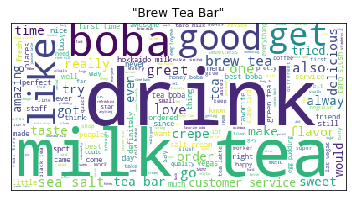

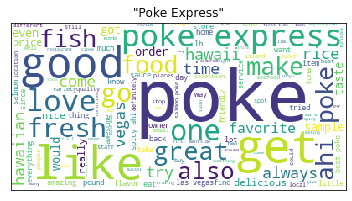

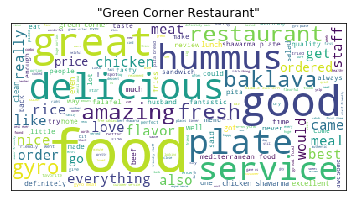

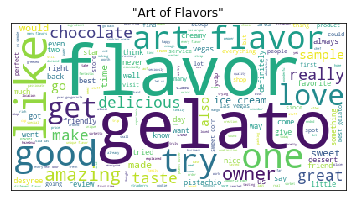

In [18]:
plt_category(br)

### Word cloud of the best mexican restaurants

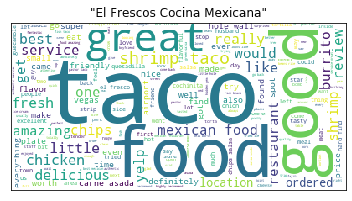

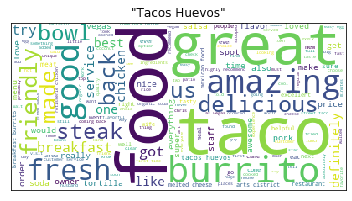

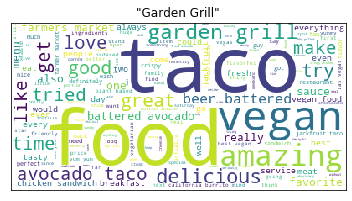

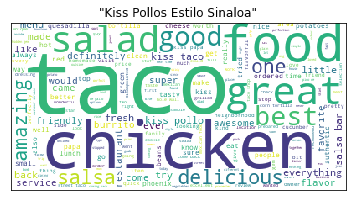

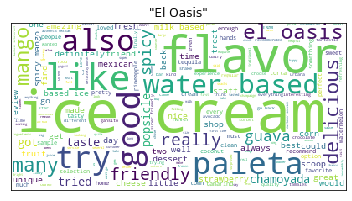

In [19]:
plt_category(bmr) # best mexican restaurants

As we can see, people which go to mexican restaurants mainly eat tacos, as this word was the most common in 4/5 word clouds. 

Lastly "El Oasis" has ice cream mentioned as most common word and business rating is 5.0, which could mean, that we found the best mexican restaurant, which serves ice cream on yelp.
From yelp page of El Oasis we confirm, that it is actually mexican ice cream restaurant with rating 4,5.

In [ ]:
stop

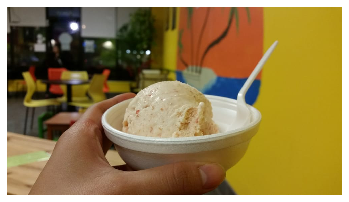

In [20]:
img=mpimg.imread('hoax.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()